# Gender Detection, Initial Approach

In [ ]:
import numpy as np
import os

import cv2
from google.colab.patches import cv2_imshow

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision
from torchvision import datasets, models, transforms


# loading dataset
!wget http://www.cs.toronto.edu/~fidler/teaching/2018/CSC420_assign/project1.zip
!unzip /content/project1.zip

Here we define 4 transformations, horizontal flip, perspective change, blur and color jitter. Each of these transformations will be applied to input data once to increase model robustness.

We also define a transformation for valid dataset which is just some resize and normalization.

In [2]:
transforms1_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms2_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms3_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms4_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

**Remove the unwanted `.mat` file**

In [3]:
! rm /content/project1/train_data/female/*.mat
! rm /content/project1/train_data/male/*.mat

We load the training images 4 times, each time with a different type of augmentation to increase the model robustness.

In [ ]:
data_dir = '/content/project1'
train_sets = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transforms1_train)
train2_sets = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transforms2_train)
train3_sets = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transforms3_train)
train4_sets = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transforms4_train)

train_comb_sets = torch.utils.data.ConcatDataset([train_sets, train2_sets, train3_sets, train4_sets])

train_dataloader = torch.utils.data.DataLoader(train_comb_sets, batch_size=16, shuffle=True, num_workers=4)

class_names = train_sets.classes

We fine-tune our model based on a pretrained ResNet18.

We change the final classifier layers to a set of linear layers with batch norm and random dropout. 

Then we also separate the classifier layers with the feature extraction convolutional layers.

In [6]:
model = models.resnet18(pretrained=True)

model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Sequential(
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=2, bias=True),
)
classifiers = []
features = []
for name,param in model.named_parameters():
    # print(name)
    if "fc" in name:
      classifiers.append(param)
    else:
      features.append(param)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Optimizer
We choose to use SGD, and adjust the learning rate for feature extraction layers and classifier layers separately.

In [7]:
# optimizer = Adam([
#                 {'params': classifiers},
#                 {'params': features, 'lr': 0.000005}
#             ], lr=0.000075)
optimizer = SGD([
                {'params': classifiers},
                {'params': features, 'lr': 0.0001}
            ], lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
model = model.cuda()

In [8]:
from tqdm import tqdm
import statistics

def train_model(epochs, dataloader, criterion, optimizer):

  epochs = epochs

  for epoch in range(epochs):
    total_loss = []
    acc = []
    for i, (train_features, train_labels) in enumerate(tqdm(dataloader)):
        if train_features.shape[0] != 1:
            train_features = train_features.cuda()
            train_labels = train_labels.cuda()
            optimizer.zero_grad()
            out = model(train_features)
            _, pred = out.max(1)
            num_correct = torch.sum((pred == train_labels).int())
            loss = criterion(out, train_labels)
            loss.backward()
            optimizer.step()
            total_loss.append((loss / 16).detach().cpu().item())
            acc.append((num_correct / 16).detach().cpu().item())
    print("Epoch: {}, Avg loss: {}, Train accuracy: {}".format(epoch, statistics.mean(total_loss), statistics.mean(acc)))

In [9]:
train_model(epochs=6, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer)

100%|██████████| 130/130 [00:05<00:00, 24.28it/s]


Epoch: 0, Avg loss: 0.026048324067288867, Train accuracy: 0.7971153846153847


100%|██████████| 130/130 [00:04<00:00, 26.45it/s]


Epoch: 1, Avg loss: 0.014246505396798826, Train accuracy: 0.9048076923076923


100%|██████████| 130/130 [00:04<00:00, 26.22it/s]


Epoch: 2, Avg loss: 0.011065836444210548, Train accuracy: 0.9293269230769231


100%|██████████| 130/130 [00:04<00:00, 26.48it/s]


Epoch: 3, Avg loss: 0.011179632119959794, Train accuracy: 0.93125


100%|██████████| 130/130 [00:04<00:00, 26.27it/s]


Epoch: 4, Avg loss: 0.0076411512223645475, Train accuracy: 0.9543269230769231


100%|██████████| 130/130 [00:04<00:00, 26.21it/s]

Epoch: 5, Avg loss: 0.007195076155655372, Train accuracy: 0.95625


In [10]:
image_path = "project1/clip_2"

In [11]:
transforms_simple = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

Here we clone and setup yolov5

In [12]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 12870, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12870 (delta 3), reused 5 (delta 1), pack-reused 12860
Receiving objects: 100% (12870/12870), 11.86 MiB | 43.07 MiB/s, done.
Resolving deltas: 100% (8938/8938), done.
     |████████████████████████████████| 596 kB 5.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Download the pretrained weight trained by me, using 70k images with 10 epochs.

In [13]:
## Download this for 50k images 8 epoches YOLOv5 medium model
# !wget https://www.dropbox.com/s/imoqdf12v59k9ov/yolo_face_50k_8epochs.zip?dl=1

## Download this for 70k images 10 epoches YOLOv5 medium model
!wget https://www.dropbox.com/s/8atygeezg7rvyf5/best.pt?dl=1

--2022-04-20 02:13:56--  https://www.dropbox.com/s/8atygeezg7rvyf5/best.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/8atygeezg7rvyf5/best.pt [following]
--2022-04-20 02:13:56--  https://www.dropbox.com/s/dl/8atygeezg7rvyf5/best.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc8b5bd104b2788260e66a5c631.dl.dropboxusercontent.com/cd/0/get/BjvRb1pyh5T3OGYI4KeCpxzW0QBzQf4XxaTegPE_u5iZGaT6ejgxOjDN9MMVQqils0wxhPPwP9mSaIsi3fOUTUFO0K68zOwqKq5SeLFlv9N61-PQJOeq8GRClUDlmDQXkw98beVaZAK9h-CiZieJJPUDU06o0z23I3vG5VkW4O2AGOslun9PWSPZ3xVJRuyFeLI/file?dl=1# [following]
--2022-04-20 02:13:57--  https://ucc8b5bd104b2788260e66a5c631.dl.dropboxusercontent.com/cd/0/get/BjvRb1pyh5T3OGYI4KeCpxzW0QBzQf4XxaTegPE_u5iZGaT6ejgxOjDN9MMV

Here we rename the file to match the actual file name (remove the ?dl=1 from dropbox naming)

In [14]:
## Use this for 50k images 8 epoches YOLOv5 medium model
# !mv yolo_face_50k_8epochs.zip?dl=1 yolo_face_50k_8epochs.zip
# !unzip yolo_face_50k_8epochs.zip

## Use this for 70k images 10 epoches YOLOv5 medium model
!mv best.pt?dl=1 best.pt

Here, we use my pretrained yolo weight for face detection.

**Remember** to change the --source path to the clip path (i.e, /content/project1/clip_2)

**Everytime** you want to start the pipeline for a new clip, **start here** by changing --source path points to the clip

In [15]:
## Use this for 50k images 8 epoches YOLOv5 medium model's weight
# ! python yolov5/detect.py --save-txt --weights /content/content/yolov5/runs/train/exp2/weights/best.pt --source /content/project1/clip_1

## Use this for 70k images 10 epoches YOLOv5 medium model's weight
! python yolov5/detect.py --save-txt --weights /content/best.pt --source /content/project1/clip_2

detect: weights=['/content/best.pt'], source=/content/project1/clip_2, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-139-gab5b917 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/135 /content/project1/clip_2/065.jpg: 384x640 4 faces, Done. (0.012s)
image 2/135 /content/project1/clip_2/066.jpg: 384x640 5 faces, Done. (0.010s)
image 3/135 /content/project1/clip_2/067.jpg: 384x640 5 faces, Done. (0.010s)
image 4/135 /content/project1/clip_2/068.jpg: 384x640 5 faces, Done. (0.010s)
image 5/135 /content/project1/clip_2/069.jpg:

Save the path above that looks like "Results saved to **yolov5/runs/detect/expxxx**"

Remember the exp number, we will need to use it later.

Below are some auxillary codes for zipping and downloading intermediate results.

In [ ]:
! zip -r clip_2_res.zip /content/yolov5/runs/detect/exp

Here we use the detected faces label created by YOLO to populate a dictionary of bounding boxes used by later codes (face tracking / gender detection).

In [16]:
path = '/content/yolov5/runs/detect/exp/labels' # <-- '/content/yolov5/runs/detect/expxxx/labels' where xxx is the path where the detected labels are stored for yolo above. 
                                                 # For example, exp5 will be /content/yolov5/runs/detect/exp5/labels
image_path = '/content/project1/clip_2' # <-- This is where clip frames are stored. Change to clip_1/2/3

dir_list = os.listdir(path)
bbox = {}
for filename in dir_list:
  f = open(os.path.join(path,filename),'r')
  lines = f.read().split('\n')
  f.close()
  img_name = filename.split('.')[0]
  img = cv2.imread(os.path.join(image_path,img_name+'.jpg'))

  if img is not None:
    boxes = []
    for line in lines:
      f = filter(None, line.split(' '))
      part = list(f)
      if len(part) > 0:
        x = float(part[1])
        y = float(part[2])
        w = float(part[3])
        h = float(part[4])
        X, Y = img.shape[1], img.shape[0]
        W = w * X
        H = h * Y
        xcenter = x * X
        ycenter = y * Y
        xmin = int(xcenter - W/2)
        ymin = int(ycenter - H/2)
        xmax = int(xcenter + W/2)
        ymax = int(ycenter + H/2)
        boxes.append((xmin, ymin, xmax, ymax))
  bbox[os.path.join(image_path,img_name+'.jpg')] = boxes

In [ ]:
bbox

# Face Tracking Across Frames

In [17]:
import cv2
import torch
import numpy as np
from collections import OrderedDict
from google.colab.patches import cv2_imshow
import dlib
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

In [18]:
clip_img_paths = []
for file in Path(image_path).iterdir():
    if ".jpg" in file.name:
        clip_img_paths.append(file)
clip_img_paths = sorted(clip_img_paths, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

In [19]:
def centroid_dist(curr, prev, curr_bbox, prev_bbox):
  """
  Compute the distance between two bounding box's centroid
  curr: current frame image
  prev: current frame image
  curr_bbox: one bounding box of the current frame
  prev_bbox: one bounding box of the current frame
  """
  curr_bbox_centroid = (curr_bbox[2]+curr_bbox[0])/2, (curr_bbox[3]+curr_bbox[1])/2
  prev_bbox_centroid = (prev_bbox[2]+prev_bbox[0])/2, (prev_bbox[3]+prev_bbox[1])/2
  # test
  #print(curr_bbox_centroid, "curr_bbox_centroid", prev_bbox_centroid, "prev_bbox_centroid")
  dist = np.linalg.norm(np.array(curr_bbox_centroid)-np.array(prev_bbox_centroid))
  return dist

In [20]:
def compute_distance(dist_function, curr, prev, bboxs_curr, bboxs_prev, boundary=50):
  # [(bbox1_index, [dist1, dist2...]), ()]
  bbox_dist = []
  bboxs_curr_assigned = []
  for bbox1_index in range(len(bboxs_curr)):
    dists = []
    for bbox2_index in range(len(bboxs_prev)):
      dist = dist_function(curr, prev, bboxs_curr[bbox1_index], bboxs_prev[bbox2_index])
      # test
      #print("test dist", dist,bboxs_curr[bbox1_index],bboxs_prev[bbox2_index], "test dist")
      dists.append(dist)
    if dists == []:
      dists = [float('inf')]
    bbox_dist.append((bbox1_index, dists))

  bbox_dist.sort(key=lambda s: min(s[1]))

  assigned_indexes = []
  for item in bbox_dist:
    bbox1_index = item[0]
    dists = item[1]
    # To prevent assigned a previously occurred value
    for i in assigned_indexes:
      dists[i] = float('inf')
    min_dist_bbox2_index = np.argmin(dists)
    assigned_indexes.append(min_dist_bbox2_index)
    # test
    #print("dists", dists)
    if dists[min_dist_bbox2_index] == float('inf'):
      min_dist_bbox2_index = None
    # If distance exceed boundary
    elif dists[min_dist_bbox2_index] >= boundary:
      min_dist_bbox2_index = None
    bboxs_curr_assigned.append((bbox1_index,min_dist_bbox2_index))
  return bboxs_curr_assigned



In [21]:
img_paths = clip_img_paths
face_detection_result = bbox
# Ordered dict to save a list of detected faces each time
# {id: (tracker, [(frame_id, bounding_box), ...])}
dist_function = centroid_dist
all_faces = {}
next_face_id = 0

# All the frames with face bounding boxes
frames_with_face_detection = set(face_detection_result.keys())

# Record the number of people that are currently tracking
# If become zero then we need to run face detection again
num_of_tracking = 0
prev_path = None
prev_img = None
bboxs_prev = []
for i in range(len(img_paths)):
  curr_path = str(img_paths[i])
  if curr_path in frames_with_face_detection:
    curr_img = cv2.imread(str(curr_path))
    boxes = face_detection_result[str(curr_path)]
    num_of_boxes = len(boxes) # If no face detected

    assigned_indexies = []
    if num_of_boxes > 0:

      #if bboxs_prev is not None and bboxs_prev != []:
      assignment = compute_distance(dist_function,curr_img, prev_img, boxes, bboxs_prev)


      all_faces[curr_path] = {}
      curr_bboxes_indexes = set(range(len(boxes)))
      for item in assignment:
        # Case 1 if curr has more boxes, 
        # Case 2 if prev has more boxes
        # Case 3 if they are equal
        bbox1_index = item[0]
        assigned_indexies.append(bbox1_index)
        curr_box = boxes[bbox1_index]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]

        min_dist_bbox2_index = item[1]
        if min_dist_bbox2_index is not None:
          prev_box = bboxs_prev[min_dist_bbox2_index]
          prev_left_up_pt = prev_box[0], prev_box[1]
          prev_righ_dow_pt = prev_box[2], prev_box[3]
          prev_box = prev_left_up_pt, prev_righ_dow_pt
          prev_assigned_id = all_faces[prev_path][prev_box]
          box_pt = left_up_pt, righ_dow_pt
          all_faces[curr_path][box_pt] = prev_assigned_id
        else:
          box_pt = left_up_pt, righ_dow_pt
          all_faces[curr_path][box_pt] = next_face_id
          next_face_id += 1
    
      unassigned_indecies = curr_bboxes_indexes.difference(set(assigned_indexies))
      for unassigned_i in unassigned_indecies:
        curr_box = boxes[unassigned_i]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]
        box_pt = left_up_pt, righ_dow_pt
        all_faces[curr_path][box_pt] = next_face_id
        next_face_id += 1
      bboxs_prev = boxes
    else:
      all_faces[curr_path] = {}
      bboxs_prev = []
    
    prev_path = curr_path
    prev_img = curr_img

In [22]:
# Draw faces based on the tracks and save to some place
save_frames = {}
for key in all_faces.keys():
  frame_path = key
  curr_img = cv2.imread(str(frame_path))
  for box in all_faces[key].keys():
    left_up_pt = box[0]
    righ_dow_pt = box[1]
    image_drew_box = cv2.rectangle(curr_img,left_up_pt,
              righ_dow_pt, (36,255,12), 1)
    cv2.putText(image_drew_box, str(all_faces[key][box]), (int(left_up_pt[0]), int(left_up_pt[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
    save_frames[frame_path] = image_drew_box

# Since nota all frames has a bounding box
# here we save those frames without bounding box to save_frames
frames_with_bbox = set(save_frames.keys())
for path in img_paths:
  if str(path) not in frames_with_bbox:
    curr_img = cv2.imread(str(path))
    save_frames[str(path)] = curr_img


Show an example of frame #23

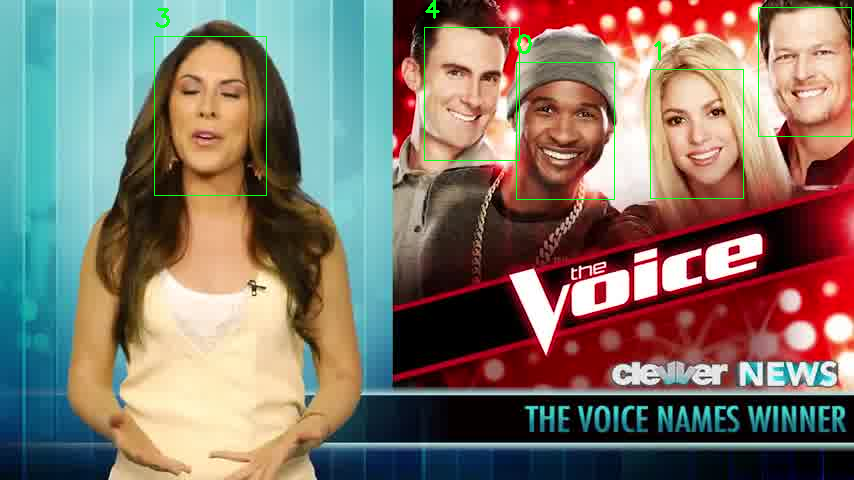

In [23]:
cv2_imshow(save_frames[list(save_frames.keys())[23]])

**Do not** run 2 cells below if you want to continue gender detection.

In [ ]:
outpath = '/content/result_clip_1'
if not os.path.isdir(outpath):
  os.makedirs(outpath)
for frame in save_frames:
    fname = os.path.split(frame)[-1]
    cv2.imwrite(os.path.join(outpath, fname),save_frames[frame])

In [ ]:
!ffmpeg -framerate 10 -pattern_type glob -i ./content/result_clip_1/'*.jpg' \
  -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"\
  -c:v libx264 -pix_fmt yuv420p out3.mp4

# Gender Detection

In [24]:

for frame in list(save_frames.keys()):
    img_name = frame.split('.')[0]
    if frame in bbox:
        bounding_boxes = bbox[frame]
        img = cv2.imread(frame)
        for box in bounding_boxes:
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            img22 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im_pil = Image.fromarray(img22)
            im_pil = im_pil.crop((xmin, ymin, xmax, ymax))

            # Use cropped face to detect gender
            im_pil = transforms_simple(im_pil).reshape(1, 3, 224, 224) 
            model.eval()
            with torch.no_grad():
              output = model(im_pil.cuda())
              _, preds = torch.max(output, 1)

            # Draw gender
            cv2.putText(save_frames[frame], str(
                class_names[preds[0]]), (xmin, ymax), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)


Show an example of gender-detected frame #40

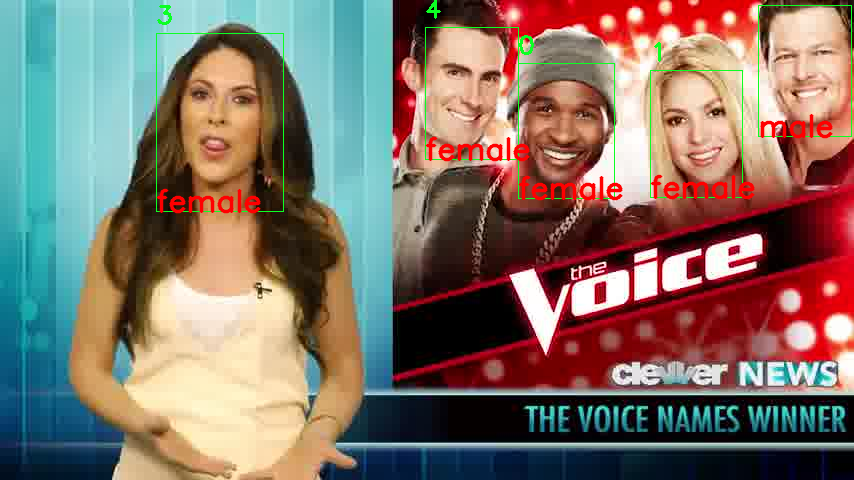

In [29]:
cv2_imshow(save_frames[list(save_frames.keys())[40]])

Below we save frames to file and zip it for downloading.

In [ ]:
if not os.path.exists('result_clip_1'):
      os.mkdir('result_clip_1')

In [ ]:
outpath = '/content/result_clip_1'
for frame in save_frames:
    fname = os.path.split(frame)[-1]
    cv2.imwrite(os.path.join(outpath, fname),save_frames[frame])


In [ ]:
!zip -r clip_3_results.zip /content/result_clip_1

You can also run below cell to generate video from frames

In [ ]:
# For clip 1 run this
# ! ffmpeg -framerate 10 -start_number 22 -i /content/result/%03d.jpg -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" output_clip1.mp4 
# For clip 2 run this
# ! ffmpeg -framerate 10 -start_number 65 -i /content/result2/%03d.jpg -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" output_clip2.mp4
# For clip 3 run this 
! ffmpeg -framerate 10 -start_number 16 -i /content/result_clip_3/%04d.jpg -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" output_clip3.mp4 

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Gender classification result looks bad

Mainly due to the lack of data (only ~250 faces each gender)
# Huge dataset to the rescue!

We got our gender classification dataset (~20k images) from kaggle: 

https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

In [30]:
!pip install kaggle

Below please upload your `kaggle.json` from your PC.

If you don't have one, you can use mine 
https://drive.google.com/file/d/1PtOXY_jvQYBT3TFIOi0ovjHFdQc_71i-/view?usp=sharing

Please no distribution

A "Choose Files" prompt will show up allowing you to upload your .json file.

In [31]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


Download the dataset.

In [32]:
!kaggle datasets download "cashutosh/gender-classification-dataset"

 95% 257M/269M [00:01<00:00, 245MB/s]
100% 269M/269M [00:01<00:00, 210MB/s]


In [ ]:
!unzip gender-classification-dataset.zip

Run below cell to train the model on new dataset.

In [34]:
data_dir = '/content'
train_sets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms1_train)
train2_sets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms2_train)
train3_sets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms3_train)
train4_sets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms4_train)

train_comb_sets = torch.utils.data.ConcatDataset([train_sets, train2_sets, train3_sets, train4_sets])

train_dataloader_big = torch.utils.data.DataLoader(train_comb_sets, batch_size=16, shuffle=True, num_workers=4)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm
import statistics

epochs = 5

for epoch in range(epochs):
  total_loss = []
  acc = []
  for i, (train_features, train_labels) in enumerate(tqdm(train_dataloader_big)):
      if train_features.shape[0] != 1:
          train_features = train_features.cuda()
          train_labels = train_labels.cuda()
          optimizer.zero_grad()
          out = model(train_features)
          _, pred = out.max(1)
          num_correct = torch.sum((pred == train_labels).int())
          loss = criterion(out, train_labels)
          loss.backward()
          optimizer.step()
          total_loss.append((loss / 16).detach().cpu().item())
          acc.append((num_correct / 16).detach().cpu().item())
  print("Epoch: {}, Avg loss: {}, Train accuracy: {}".format(epoch, statistics.mean(total_loss), statistics.mean(acc)))


100%|██████████| 11753/11753 [06:58<00:00, 28.11it/s]


Epoch: 0, Avg loss: 0.007003380372533586, Train accuracy: 0.9594997022036926


100%|██████████| 11753/11753 [06:58<00:00, 28.11it/s]


Epoch: 1, Avg loss: 0.004747259096441121, Train accuracy: 0.9731664255934654


100%|██████████| 11753/11753 [06:58<00:00, 28.10it/s]


Epoch: 2, Avg loss: 0.00391523335136265, Train accuracy: 0.9777663149834085


100%|██████████| 11753/11753 [06:58<00:00, 28.10it/s]


Epoch: 3, Avg loss: 0.003200997192229729, Train accuracy: 0.981579171275419


100%|██████████| 11753/11753 [06:58<00:00, 28.11it/s]

Epoch: 4, Avg loss: 0.0026570982401105127, Train accuracy: 0.9848336594911937


Run below cell to validate the model.

In [ ]:
valid_dir = '/content'
valid_sets = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transforms1_train)
valid_dataloader_big = torch.utils.data.DataLoader(valid_sets, batch_size=16, shuffle=True, num_workers=4)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm
import statistics

epochs = 1

for epoch in range(epochs):
  model.eval()
  total_loss = []
  acc = []
  for i, (valid_features, valid_labels) in enumerate(tqdm(valid_dataloader_big)):
      if valid_features.shape[0] != 1:
        with torch.no_grad():
          valid_features = valid_features.cuda()
          valid_labels = valid_labels.cuda()
          out = model(valid_features)
          _, pred = out.max(1)
          num_correct = torch.sum((pred == valid_labels).int())
          loss = criterion(out, valid_labels)
          total_loss.append((loss / 16).detach().cpu().item())
          acc.append((num_correct / 16).detach().cpu().item())
  print("Epoch: {}, Avg loss: {}, Valid accuracy: {}".format(epoch, statistics.mean(total_loss), statistics.mean(acc)))

100%|██████████| 729/729 [00:14<00:00, 51.05it/s]

Epoch: 0, Avg loss: 0.004863296787996836, Valid accuracy: 0.9730425824175825


Below cells re-inference the model again and detect gender.

The codes below are copy pasted from above, starting from "Face Tracking Across Frames" title to the end of "Gender Detection" title.

If you want you can go up and run those cells instead. Or you can run all cells below to produce the final output.

In [41]:
img_paths = clip_img_paths
face_detection_result = bbox
# Ordered dict to save a list of detected faces each time
# {id: (tracker, [(frame_id, bounding_box), ...])}
dist_function = centroid_dist
all_faces = {}
next_face_id = 0

# All the frames with face bounding boxes
frames_with_face_detection = set(face_detection_result.keys())

# Record the number of people that are currently tracking
# If become zero then we need to run face detection again
num_of_tracking = 0
prev_path = None
prev_img = None
bboxs_prev = []
for i in range(len(img_paths)):
  curr_path = str(img_paths[i])
  if curr_path in frames_with_face_detection:
    curr_img = cv2.imread(str(curr_path))
    boxes = face_detection_result[str(curr_path)]
    num_of_boxes = len(boxes) # If no face detected

    assigned_indexies = []
    if num_of_boxes > 0:

      #if bboxs_prev is not None and bboxs_prev != []:
      assignment = compute_distance(dist_function,curr_img, prev_img, boxes, bboxs_prev)


      all_faces[curr_path] = {}
      curr_bboxes_indexes = set(range(len(boxes)))
      for item in assignment:
        # Case 1 if curr has more boxes, 
        # Case 2 if prev has more boxes
        # Case 3 if they are equal
        bbox1_index = item[0]
        assigned_indexies.append(bbox1_index)
        curr_box = boxes[bbox1_index]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]

        min_dist_bbox2_index = item[1]
        if min_dist_bbox2_index is not None:
          prev_box = bboxs_prev[min_dist_bbox2_index]
          prev_left_up_pt = prev_box[0], prev_box[1]
          prev_righ_dow_pt = prev_box[2], prev_box[3]
          prev_box = prev_left_up_pt, prev_righ_dow_pt
          prev_assigned_id = all_faces[prev_path][prev_box]
          box_pt = left_up_pt, righ_dow_pt
          all_faces[curr_path][box_pt] = prev_assigned_id
        else:
          box_pt = left_up_pt, righ_dow_pt
          all_faces[curr_path][box_pt] = next_face_id
          next_face_id += 1
    
      unassigned_indecies = curr_bboxes_indexes.difference(set(assigned_indexies))
      for unassigned_i in unassigned_indecies:
        curr_box = boxes[unassigned_i]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]
        box_pt = left_up_pt, righ_dow_pt
        all_faces[curr_path][box_pt] = next_face_id
        next_face_id += 1
      bboxs_prev = boxes
    else:
      all_faces[curr_path] = {}
      bboxs_prev = []
    
    prev_path = curr_path
    prev_img = curr_img

In [42]:
# Draw faces based on the tracks and save to some place
save_frames = {}
for key in all_faces.keys():
  frame_path = key
  curr_img = cv2.imread(str(frame_path))
  for box in all_faces[key].keys():
    left_up_pt = box[0]
    righ_dow_pt = box[1]
    image_drew_box = cv2.rectangle(curr_img,left_up_pt,
              righ_dow_pt, (36,255,12), 1)
    cv2.putText(image_drew_box, str(all_faces[key][box]), (int(left_up_pt[0]), int(left_up_pt[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
    save_frames[frame_path] = image_drew_box

# Since nota all frames has a bounding box
# here we save those frames without bounding box to save_frames
frames_with_bbox = set(save_frames.keys())
for path in img_paths:
  if str(path) not in frames_with_bbox:
    curr_img = cv2.imread(str(path))
    save_frames[str(path)] = curr_img

In [43]:
for frame in list(save_frames.keys()):
    img_name = frame.split('.')[0]
    if frame in bbox:
        bounding_boxes = bbox[frame]
        img = cv2.imread(frame)
        for box in bounding_boxes:
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            img22 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im_pil = Image.fromarray(img22)
            im_pil = im_pil.crop((xmin, ymin, xmax, ymax))

            # Use cropped face to detect gender
            im_pil = transforms_simple(im_pil).reshape(1, 3, 224, 224) 
            model.eval()
            with torch.no_grad():
              output = model(im_pil.cuda())
              _, preds = torch.max(output, 1)

            # Draw gender
            cv2.putText(save_frames[frame], str(
                class_names[preds[0]]), (xmin, ymax), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

In [44]:
if not os.path.exists('result_clip_2'):
      os.mkdir('result_clip_2')

In [45]:
outpath = '/content/result_clip_2'
for frame in save_frames:
    fname = os.path.split(frame)[-1]
    cv2.imwrite(os.path.join(outpath, fname),save_frames[frame])

# Download results

Lastly we zip our results, allowing it to be downloaded.

In [ ]:
!zip -r clip_2_results.zip /content/result_clip_2

Below code is to convert ipynb file to html for submission, please do not run.

In [ ]:
%%shell
jupyter nbconvert --to html /content/detection.ipynb

[NbConvertApp] Converting notebook /content/detection.ipynb to html
[NbConvertApp] Writing 2024890 bytes to /content/detection.html
